In [ ]:
! pip install yfinance pandas numpy matplotlib statsmodels scikit-learn


# Recuperation de la DATA

In [ ]:
import os
import numpy as np
import pandas as pd
import yfinance as yf

def download_monthly_series(ticker: str, start: str, end: str) -> pd.Series:
    
    df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
    if df.empty:
        raise ValueError(f"Aucune donnée téléchargée pour {ticker}. Vérifie le ticker.")

    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    s = df[col].copy()

    s = s.resample("ME").last()
    s.name = ticker
    return s


def build_dataset(
    start: str = "2014-01-01",
    end: str = "2025-01-01",
    growth: str = "VUG",
    value: str = "VTV",
    rate: str = "^FVX",
    vol_window: int = 6,
    out_csv: str = "data/final_dataset.csv",
) -> pd.DataFrame:
    
    g_px = download_monthly_series(growth, start, end)
    v_px = download_monthly_series(value, start, end)
    r_px = download_monthly_series(rate, start, end)

    df = pd.concat([g_px, v_px, r_px], axis=1)


    df = df.dropna(how="any")

    # Rendements en %
    df["ret_growth"] = df[growth].pct_change() * 100.0
    df["ret_value"] = df[value].pct_change() * 100.0

    df["rate_5y"] = df[rate]

    df["rate_5y_change"] = df["rate_5y"].diff()

    df["spread"] = df["ret_growth"] - df["ret_value"]

    df["spread_vol"] = df["spread"].rolling(vol_window).std()

    df = df.dropna(how="any")
    df = df.fillna(df.median(numeric_only=True))

    final_cols = [
        growth, value, rate,
        "ret_growth", "ret_value",
        "spread", "rate_5y", "rate_5y_change", "spread_vol",
    ]
    df_final = df[final_cols].copy()

    # Export CSV
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    df_final.to_csv(out_csv, index=True)

    return df_final


if __name__ == "__main__":
    dataset = build_dataset()
    print("Dataset généré :", dataset.shape)
    print(dataset.tail())

Dataset généré : (126, 9)
Ticker             VUG         VTV   ^FVX  ret_growth  ret_value    spread  \
Date                                                                         
2024-08-31  372.925751  167.306747  3.715    2.246129   2.880801 -0.634672   
2024-09-30  381.699219  169.867264  3.577    2.352605   1.530432  0.822172   
2024-10-31  380.695068  167.522186  4.155   -0.263074  -1.380535  1.117462   
2024-11-30  406.752747  176.970596  4.055    6.844764   5.640095  1.204669   
2024-12-31  408.577393  165.692764  4.380    0.448588  -6.372715  6.821304   

Ticker      rate_5y  rate_5y_change  spread_vol  
Date                                             
2024-08-31    3.715          -0.285    4.740609  
2024-09-30    3.577          -0.138    4.403803  
2024-10-31    4.155           0.578    4.388222  
2024-11-30    4.055          -0.100    4.225075  
2024-12-31    4.380           0.325    4.281800  


In [3]:
# econometric_analysis_OLS
import pandas as pd
import statsmodels.api as sm


def run_ols(csv_path: str = "data/final_dataset.csv"):
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    # Variable expliquée
    y = df["spread"]

    # Variables explicatives
    X = df[["rate_5y", "rate_5y_change"]].copy()
    X = sm.add_constant(X)  # intercept

    model = sm.OLS(y, X).fit()

    print("\n===== OLS: Spread ~ Rate Level + Rate Change =====\n")
    print(model.summary())

    # Sorties "prof-friendly"
    beta_rate = model.params.get("rate_5y", None)
    p_rate = model.pvalues.get("rate_5y", None)

    beta_change = model.params.get("rate_5y_change", None)
    p_change = model.pvalues.get("rate_5y_change", None)

    r2 = model.rsquared

    print("\n--- Interprétation rapide ---")
    print(f"Beta taux (rate_5y)       : {beta_rate:.4f} | p-value = {p_rate:.4f}")
    print(f"Beta Δtaux (rate_change) : {beta_change:.4f} | p-value = {p_change:.4f}")
    print(f"R²                       : {r2:.4f}")

    return model


if __name__ == "__main__":
    run_ols()



===== OLS: Spread ~ Rate Level + Rate Change =====

                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     7.179
Date:                Wed, 11 Feb 2026   Prob (F-statistic):            0.00113
Time:                        09:15:52   Log-Likelihood:                -320.28
No. Observations:                 126   AIC:                             646.6
Df Residuals:                     123   BIC:                             655.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------


===== OLS: Spread ~ Rate Level + Rate Change =====

                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     7.179
Date:                Wed, 11 Feb 2026   Prob (F-statistic):            0.00113
Time:                        09:19:19   Log-Likelihood:                -320.28
No. Observations:                 126   AIC:                             646.6
Df Residuals:                     123   BIC:                             655.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

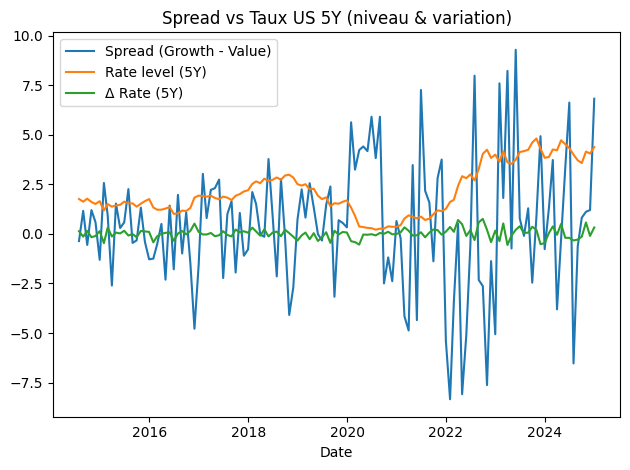

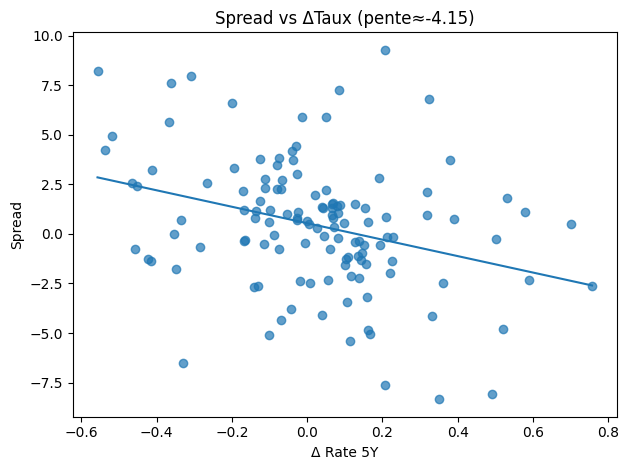

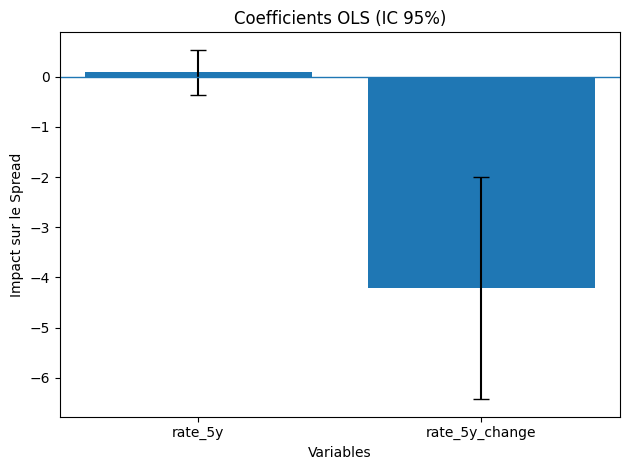

In [7]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

def run_ols(csv_path: str = "data/final_dataset.csv"):
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    y = df["spread"]
    X = sm.add_constant(df[["rate_5y", "rate_5y_change"]])
    model = sm.OLS(y, X).fit()

    print("\n===== OLS: Spread ~ Rate Level + Rate Change =====\n")
    print(model.summary())

    print("\n--- Interprétation rapide ---")
    print(f"Beta taux (rate_5y)       : {model.params['rate_5y']:.4f} | p-value = {model.pvalues['rate_5y']:.4f}")
    print(f"Beta Δtaux (rate_change) : {model.params['rate_5y_change']:.4f} | p-value = {model.pvalues['rate_5y_change']:.4f}")
    print(f"R²                       : {model.rsquared:.4f}")

    return df, model


def plots_for_presentation(df: pd.DataFrame, model):
    # (1) Série temporelle: Spread + Taux + ΔTaux
    plt.figure()
    plt.plot(df.index, df["spread"], label="Spread (Growth - Value)")
    plt.plot(df.index, df["rate_5y"], label="Rate level (5Y)")
    plt.plot(df.index, df["rate_5y_change"], label="Δ Rate (5Y)")
    plt.title("Spread vs Taux US 5Y (niveau & variation)")
    plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()

    # (2) Scatter Spread vs ΔTaux + droite (visualisation très parlante)
    x, y = df["rate_5y_change"].values, df["spread"].values
    b1, b0 = np.polyfit(x, y, 1)  # y ≈ b1*x + b0
    xs = np.linspace(x.min(), x.max(), 100)
    plt.figure()
    plt.scatter(x, y, alpha=0.7)
    plt.plot(xs, b1*xs + b0)
    plt.title(f"Spread vs ΔTaux (pente≈{b1:.2f})")
    plt.xlabel("Δ Rate 5Y"); plt.ylabel("Spread"); plt.tight_layout(); plt.show()

    # (3) Coefficients + IC 95% (le graphique “résultat OLS”)
    params = model.params.drop("const")
    ci = model.conf_int().loc[params.index]
    plt.figure()
    plt.bar(params.index, params.values, yerr=[params.values-ci[0].values, ci[1].values-params.values], capsize=6)
    plt.axhline(0, linewidth=1)
    plt.title("Coefficients OLS (IC 95%)")
    plt.xlabel("Variables"); plt.ylabel("Impact sur le Spread"); plt.tight_layout(); plt.show()


if __name__ == "__main__":
    df, model = run_ols()
    plots_for_presentation(df, model)


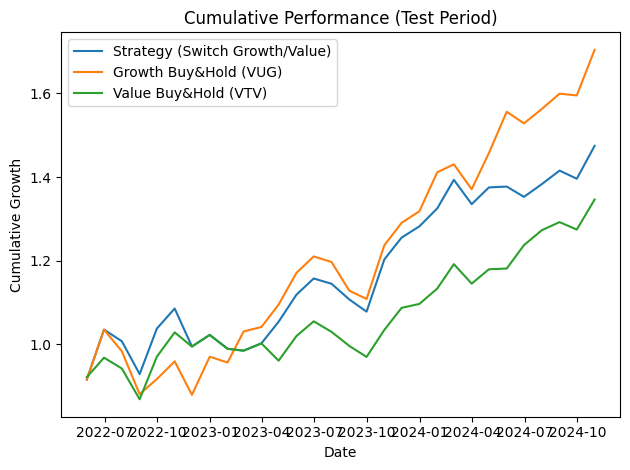

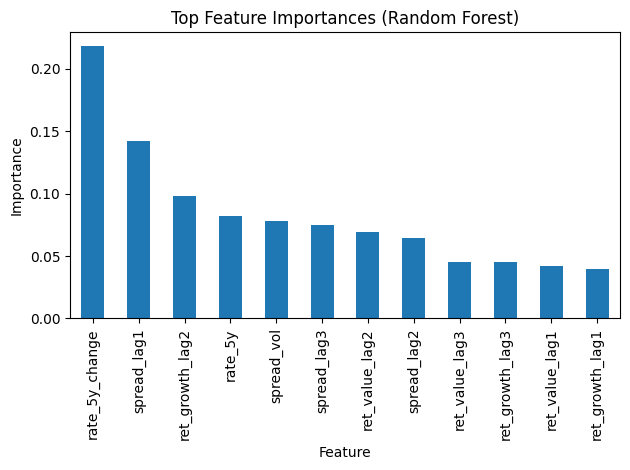


===== Résultats Backtest (Test) =====
Strategy total return: 47.46%
Growth B&H total     : 70.45%
Value  B&H total     : 34.62%


In [8]:
# ml_strategy.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor


def make_features(df: pd.DataFrame, n_lags: int = 3) -> pd.DataFrame:
    out = df.copy()

    # Target: spread du mois suivant
    out["spread_fwd"] = out["spread"].shift(-1)

    # Lags (rendements passés + spread passé)
    for k in range(1, n_lags + 1):
        out[f"ret_growth_lag{k}"] = out["ret_growth"].shift(k)
        out[f"ret_value_lag{k}"] = out["ret_value"].shift(k)
        out[f"spread_lag{k}"] = out["spread"].shift(k)

    # Features de taux + vol déjà présentes
    feature_cols = (
        ["rate_5y", "rate_5y_change", "spread_vol"]
        + [f"ret_growth_lag{k}" for k in range(1, n_lags + 1)]
        + [f"ret_value_lag{k}" for k in range(1, n_lags + 1)]
        + [f"spread_lag{k}" for k in range(1, n_lags + 1)]
    )

    out = out.dropna()
    return out, feature_cols


def time_split(df: pd.DataFrame, train_ratio: float = 0.75):
    n = len(df)
    cut = int(n * train_ratio)
    train = df.iloc[:cut].copy()
    test = df.iloc[cut:].copy()
    return train, test


def plot_cum_returns(index, series_dict, title):
    plt.figure()
    for label, rets in series_dict.items():
        cum = (1.0 + rets / 100.0).cumprod()
        plt.plot(index, cum, label=label)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Growth")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, feature_cols):
    imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    plt.figure()
    imp.head(15).plot(kind="bar")
    plt.title("Top Feature Importances (Random Forest)")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


def run_ml_strategy(
    csv_path: str = "data/final_dataset.csv",
    n_lags: int = 3,
    train_ratio: float = 0.75,
    n_estimators: int = 500,
    random_state: int = 42
):
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    data, feature_cols = make_features(df, n_lags=n_lags)
    train, test = time_split(data, train_ratio=train_ratio)

    X_train = train[feature_cols]
    y_train = train["spread_fwd"]
    X_test = test[feature_cols]
    y_test = test["spread_fwd"]

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        min_samples_leaf=2,
        max_depth=None,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    test["pred_spread_fwd"] = model.predict(X_test)

    # Backtest (décision sur le mois t pour investir sur t+1 => cohérent avec target fwd)
    # Ici: pred_spread_fwd estimé à la date t, on prend la performance réelle du mois suivant:
    test["strategy_ret"] = np.where(
        test["pred_spread_fwd"] > 0,
        test["ret_growth"].shift(-1),
        test["ret_value"].shift(-1),
    )

    # Benchmarks (mêmes dates que strategy_ret)
    test["growth_bh"] = test["ret_growth"].shift(-1)
    test["value_bh"] = test["ret_value"].shift(-1)

    # Nettoyage final (dernier point devient NaN avec shift(-1))
    test = test.dropna(subset=["strategy_ret", "growth_bh", "value_bh"])

    # Graph perf cumulée
    plot_cum_returns(
        test.index,
        {
            "Strategy (Switch Growth/Value)": test["strategy_ret"],
            "Growth Buy&Hold (VUG)": test["growth_bh"],
            "Value Buy&Hold (VTV)": test["value_bh"],
        },
        title="Cumulative Performance (Test Period)"
    )

    # Importance des variables
    plot_feature_importance(model, feature_cols)

    # Quick metrics
    strat_total = (1.0 + test["strategy_ret"] / 100.0).prod() - 1.0
    growth_total = (1.0 + test["growth_bh"] / 100.0).prod() - 1.0
    value_total = (1.0 + test["value_bh"] / 100.0).prod() - 1.0

    print("\n===== Résultats Backtest (Test) =====")
    print(f"Strategy total return: {strat_total*100:.2f}%")
    print(f"Growth B&H total     : {growth_total*100:.2f}%")
    print(f"Value  B&H total     : {value_total*100:.2f}%")

    return model, test


if __name__ == "__main__":
    run_ml_strategy()

